# Contextual Quantum Neural Network for Stock Pricing

## Preprocessing of data 
Convert log-returns into probability distribution of qubit features

In [14]:
#imports
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import pennylane as qml
from itertools import product

In [7]:
VERBOSE = True

N_BINS = 2 # change from binary csv

df_binary = pd.read_csv("binary_stock_differences.csv")

print(df_binary.head())

   AAPL  AMZN  GOOG  MSFT
0     1     1     1     1
1     1     1     1     1
2     1     1     1     1
3     1     1     1     1
4     1     1     1     1


In [8]:

#split into windows
WINDOW_SIZE = 4 #time windows of 4

df = pd.DataFrame(columns=['context','window'])
    
for context, ticker in enumerate(df_binary.columns):
        
    stock_series = df_binary[ticker]
        
    # Slide a window across this one stock's time series
    # We stop (window_size - 1) from the end
    for i in range(len(stock_series) - WINDOW_SIZE + 1):
            
        # The full window (e.g., 4 log-returns)
        window = stock_series.iloc[i : i + WINDOW_SIZE]

        df.loc[len(df)] = [context, window.values]

print(df.head(15))

    context        window
0         0  [1, 1, 1, 1]
1         0  [1, 1, 1, 1]
2         0  [1, 1, 1, 1]
3         0  [1, 1, 1, 1]
4         0  [1, 1, 1, 1]
5         0  [1, 1, 1, 0]
6         0  [1, 1, 0, 1]
7         0  [1, 0, 1, 0]
8         0  [0, 1, 0, 0]
9         0  [1, 0, 0, 0]
10        0  [0, 0, 0, 0]
11        0  [0, 0, 0, 0]
12        0  [0, 0, 0, 0]
13        0  [0, 0, 0, 0]
14        0  [0, 0, 0, 0]


In [28]:
# split into train and test sets with stratification by context

TRAIN_RATIO = 0.8

# Stratify by context to ensure equal distribution in train and test sets
df_train = pd.DataFrame(columns=['context','window'])
df_test = pd.DataFrame(columns=['context','window'])

# Group by context and split each group
for context_val in sorted(df['context'].unique()):
    context_df = df[df['context'] == context_val].reset_index(drop=True)
    
    # Split this context's data
    n_rows = len(context_df)
    split_index = int(n_rows * TRAIN_RATIO)
    
    # Add to train and test
    df_train = pd.concat([df_train, context_df.iloc[:split_index]], ignore_index=True)
    df_test = pd.concat([df_test, context_df.iloc[split_index:]], ignore_index=True)

# Reset indices
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(df_train.shape)
print(df_test.shape)


(4800, 2)
(1204, 2)



Probability distribution of feature patterns:
--------------------------------------------------
Pattern    | Probability | Count
--------------------------------------------------
[0,0,0]    |      0.255 |  1226
[0,0,1]    |      0.070 |   338
[0,1,0]    |      0.025 |   120
[0,1,1]    |      0.075 |   362
[1,0,0]    |      0.070 |   338
[1,0,1]    |      0.031 |   148
[1,1,0]    |      0.076 |   366
[1,1,1]    |      0.396 |  1902

Total probability: 1.000000
Total samples: 4800


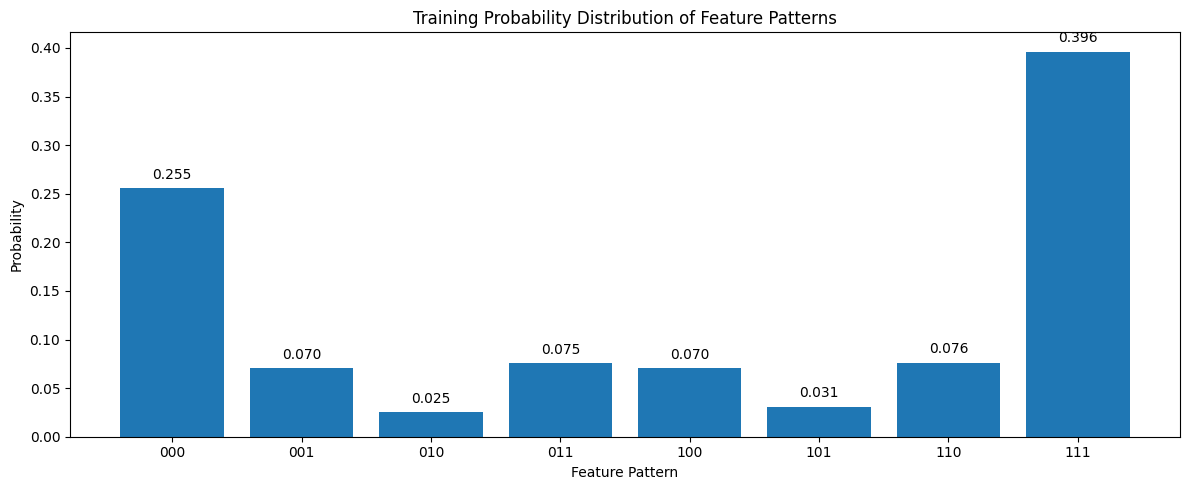


Probability distribution of output patterns:
--------------------------------------------------
Pattern    | Probability | Count
--------------------------------------------------
[0,0,0,0]  |      0.197 |   947
[0,0,0,1]  |      0.058 |   279
[0,0,1,0]  |      0.015 |    74
[0,0,1,1]  |      0.055 |   264
[0,1,0,0]  |      0.018 |    84
[0,1,0,1]  |      0.007 |    36
[0,1,1,0]  |      0.015 |    70
[0,1,1,1]  |      0.061 |   292
[1,0,0,0]  |      0.058 |   279
[1,0,0,1]  |      0.012 |    59
[1,0,1,0]  |      0.010 |    46
[1,0,1,1]  |      0.021 |   102
[1,1,0,0]  |      0.053 |   254
[1,1,0,1]  |      0.023 |   112
[1,1,1,0]  |      0.062 |   296
[1,1,1,1]  |      0.335 |  1606

Total probability: 1.000000
Total samples: 4800


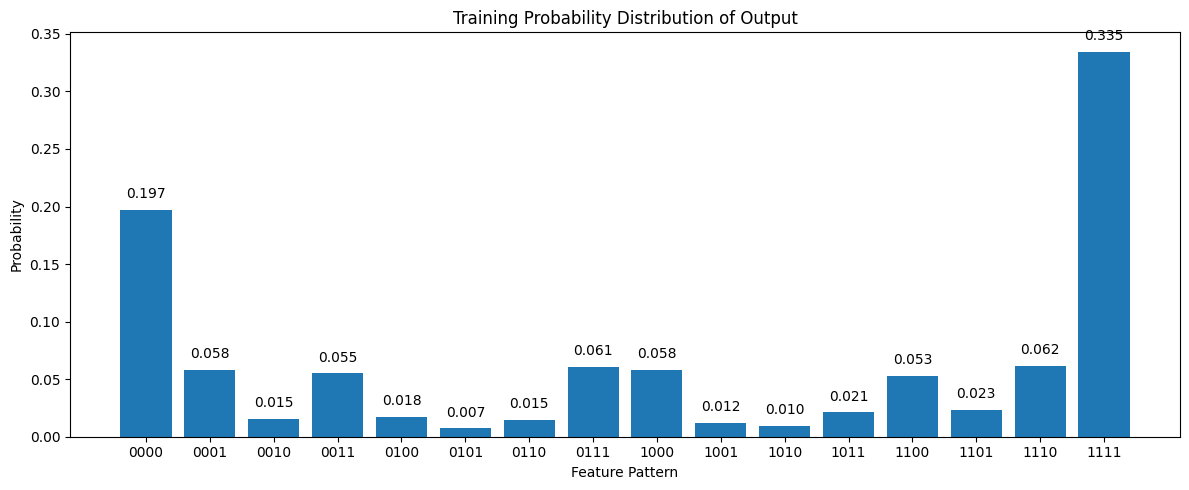


Probability distribution of context patterns:
--------------------------------------------------
Pattern    | Probability
--------------------------------------------------
00 |      0.250
01 |      0.250
10 |      0.250
11 |      0.250

Total probability: 1.000000


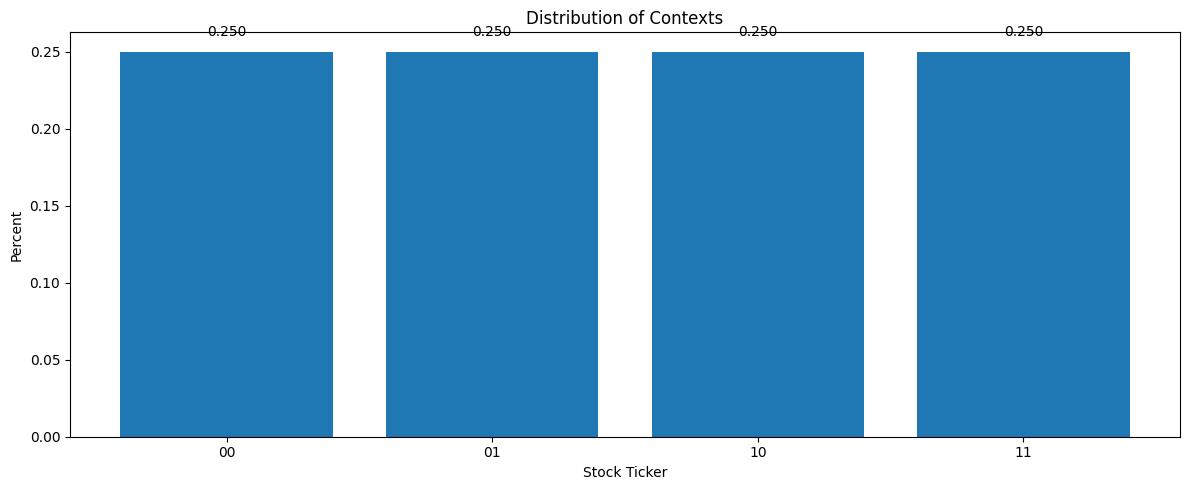

In [29]:
# Analyze global probability distribution of feature patterns

# Get dimensions
n_features = WINDOW_SIZE - 1  # Should be 3
n_feat_patterns = 2**n_features  # 8 possible patterns for 3 binary features

# Generate all possible patterns in natural binary order
feat_patterns = np.array(list(product([0, 1], repeat=n_features)))
feat_pattern_strs = [''.join(map(str, p)) for p in feat_patterns]

# Stack all feature vectors into a 2D array
all_features = np.stack(df_train['window'].apply(lambda x: x[:WINDOW_SIZE-1]))

# Count occurrences of each pattern
feature_counts = np.zeros(n_feat_patterns)
for i, pattern in enumerate(feat_patterns):
    matches = np.all(all_features == pattern, axis=1)
    feature_counts[i] = np.sum(matches)

# Convert to probabilities
feature_probs = feature_counts / feature_counts.sum()

if VERBOSE:
    # Print probabilities in natural binary order
    print("\nProbability distribution of feature patterns:")
    print("-" * 50)
    print("Pattern    | Probability | Count")
    print("-" * 50)
    for i in range(n_feat_patterns):
        pattern_str = f"[{','.join(map(str, feat_patterns[i]))}]"
        print(f"{pattern_str:10s} | {feature_probs[i]:10.3f} | {int(feature_counts[i]):5d}")

# Verify distribution sums to 1
print(f"\nTotal probability: {feature_probs.sum():.6f}")
print(f"Total samples: {int(feature_counts.sum())}")

# Plot bar chart (keeping natural binary order)
plt.figure(figsize=(12, 5))
plt.bar(feat_pattern_strs, feature_probs)
plt.ylabel('Probability')
plt.xlabel('Feature Pattern')
plt.title('Training Probability Distribution of Feature Patterns')

# Add probability values on top of bars
for i, v in enumerate(feature_probs):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

#Do the same thing but for target output probabilities
# Get dimensions
n_window = WINDOW_SIZE  # Should be 4
n_out_patterns = 2**n_window  # 16 possible patterns for 4 binary features

# Generate all possible patterns in natural binary order
out_patterns = np.array(list(product([0, 1], repeat=n_window)))
out_pattern_strs = [''.join(map(str, p)) for p in out_patterns]

# Stack all feature vectors into a 2D array
all_windows = np.stack(df_train['window'])

# Count occurrences of each pattern
window_counts = np.zeros(n_out_patterns)
for i, pattern in enumerate(out_patterns):
    matches = np.all(all_windows == pattern, axis=1)
    window_counts[i] = np.sum(matches)

# Convert to probabilities
output_probs = window_counts / window_counts.sum()

if VERBOSE:
    # Print probabilities in natural binary order
    print("\nProbability distribution of output patterns:")
    print("-" * 50)
    print("Pattern    | Probability | Count")
    print("-" * 50)
    for i in range(n_out_patterns):
        pattern_str = f"[{','.join(map(str, out_patterns[i]))}]"
        print(f"{pattern_str:10s} | {output_probs[i]:10.3f} | {int(window_counts[i]):5d}")

# Verify distribution sums to 1
print(f"\nTotal probability: {output_probs.sum():.6f}")
print(f"Total samples: {int(window_counts.sum())}")

# Plot bar chart (keeping natural binary order)
plt.figure(figsize=(12, 5))
plt.bar(out_pattern_strs, output_probs)
plt.ylabel('Probability')
plt.xlabel('Feature Pattern')
plt.title('Training Probability Distribution of Output')

# Add probability values on top of bars
for i, v in enumerate(output_probs):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# get context distribution
n_context = np.log2(df_binary.shape[1]).astype(int)

context_states = np.array(list(product([0, 1], repeat=n_context)))
context_strs = [''.join(map(str, p)) for p in context_states]

context_dist = df_train['context'].value_counts(normalize=True).sort_index()

if VERBOSE:
    # Print probabilities in natural binary order
    print("\nProbability distribution of context patterns:")
    print("-" * 50)
    print("Pattern    | Probability")
    print("-" * 50)
    for i in range(len(context_strs)):
        print(f"{context_strs[i]} | {context_dist[i]:10.3f}")
# Verify distribution sums to 1
print(f"\nTotal probability: {context_dist.sum():.6f}")

plt.figure(figsize=(12,5))
plt.bar(context_strs, context_dist)
plt.ylabel('Percent')
plt.xlabel('Stock Ticker')
plt.title('Distribution of Contexts')

# Add probability values on top of bars
for i, v in enumerate(context_dist):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()


## Create state-preparation circuit to load input probability distribution into an approximate quantum state

In [30]:
# State preparation circuit (hardware-efficient ansatz)

def hardware_efficient_ansatz(params, wires, L):
    #Hadamard layer
    for wire in wires:
        qml.Hadamard(wire)

    for l in range(L):
        for i in range(len(wires)):
            qml.RY(params[l][i][0], wires=wires[i])
            qml.RZ(params[l][i][1], wires=wires[i])

        for i in range(len(wires)):
            qml.CNOT(wires=[wires[i], wires[(i + 1) % len(wires)]])

In [31]:


# function to train hardware-efficient-ansatz

L_SP = 2
N_EPOCHS_SP = 10000
LEARNING_RATE_SP = 0.1
INIT_PARAM_SCALE = 0.01
PATIENCE_SP = 200  # early-stopping patience (epochs)
MIN_DELTA_SP = 1e-8  # minimum improvement to reset patience
PRINT_INTERVAL = 50

def train_ansatz(target_probs, name, L=L_SP, lr=LEARNING_RATE_SP):

    num_wires = int(np.log2(len(target_probs)))

    dev_sp = qml.device("default.qubit", wires=num_wires)

    @qml.qnode(dev_sp, interface='torch', diff_method='spsa')
    def sp_circuit(params, num_wires):

        wires = range(num_wires)

        hardware_efficient_ansatz(params, wires, L)

        return qml.probs(wires=wires)

    # Initialize parameters as a NumPy array
    params_sp = nn.Parameter(torch.randn(L, num_wires, 2) * INIT_PARAM_SCALE)

    # Create SPSA optimizer
    opt_sp = torch.optim.Adam([params_sp], lr=lr)

    loss_fn_sp = nn.MSELoss()

    # Training loop using SPSA optimizer with early stopping
    losses_sp = []

    best_loss = float('inf')
    epochs_no_improve = 0
    # Keep a copy of best parameters (detached tensor)
    best_params_sp = params_sp.detach().clone()

    print("Beginning Ansatz Training for", name)

    for epoch in range(N_EPOCHS_SP):
        # Single SPSA update step

        y_pred = sp_circuit(params_sp, num_wires)

        loss = loss_fn_sp(y_pred, target_probs)

        loss.backward()

        opt_sp.step()

        opt_sp.zero_grad()

        loss_value = loss.item()
        losses_sp.append(loss_value)

        # Check improvement for early stopping
        if loss_value < best_loss - MIN_DELTA_SP:
            best_loss = loss_value
            epochs_no_improve = 0
            best_params_sp = params_sp.detach().clone()
        else:
            epochs_no_improve += 1

        # Print progress
        if (epoch + 1) % PRINT_INTERVAL == 0 or epoch == N_EPOCHS_SP - 1:
            print(f"Epoch {epoch+1} - MSE Loss: {loss_value:.9f} - Best: {best_loss:.9f} - Stalled: {epochs_no_improve}/{PATIENCE_SP}")

        # Early stopping check
        if epochs_no_improve >= PATIENCE_SP:
            print(f"Early stopping at epoch {epoch+1} (no improvement for {PATIENCE_SP} epochs).")
            break

    target_out_np = target_probs.detach().numpy()
    final_out_np = sp_circuit(best_params_sp, num_wires).detach().numpy()

    # Plot training loss
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(losses_sp) + 1), losses_sp)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('State Preparation for ' + name)
    plt.grid(True)
    plt.show()

    patterns = np.array(list(product([0, 1], repeat=num_wires)))
    pattern_strs = [''.join(map(str, p)) for p in patterns]

    #Plot target probabilities and predicted probabilites
    x = np.arange(len(pattern_strs))
    width = 0.35  # Width of the bars

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, target_out_np, width, label='Target')
    plt.bar(x + width/2, final_out_np, width, label='Predicted')

    plt.ylabel('Probability')
    plt.xlabel('Feature Pattern')
    plt.title('Predicted vs. Target Probability Distribution of ' + name + ' Patterns')
    plt.xticks(x, pattern_strs)
    plt.legend()

    # Add probability values on top of bars
    for i, (v1, v2) in enumerate(zip(target_out_np, final_out_np)):
        plt.text(i - width/2, v1 + 0.01, f'{v1:.3f}', ha='center')
        plt.text(i + width/2, v2 + 0.01, f'{v2:.3f}', ha='center')

    plt.tight_layout()
    plt.show()

    print(qml.draw(sp_circuit)(best_params_sp, num_wires))    

    return best_params_sp


Beginning Ansatz Training for Features
Epoch 50 - MSE Loss: 0.000212307 - Best: 0.000174686 - Stalled: 9/200
Epoch 50 - MSE Loss: 0.000212307 - Best: 0.000174686 - Stalled: 9/200
Epoch 100 - MSE Loss: 0.000096995 - Best: 0.000096995 - Stalled: 0/200
Epoch 100 - MSE Loss: 0.000096995 - Best: 0.000096995 - Stalled: 0/200
Epoch 150 - MSE Loss: 0.000062440 - Best: 0.000062440 - Stalled: 0/200
Epoch 150 - MSE Loss: 0.000062440 - Best: 0.000062440 - Stalled: 0/200
Epoch 200 - MSE Loss: 0.000022345 - Best: 0.000022345 - Stalled: 0/200
Epoch 200 - MSE Loss: 0.000022345 - Best: 0.000022345 - Stalled: 0/200
Epoch 250 - MSE Loss: 0.000004243 - Best: 0.000004243 - Stalled: 0/200
Epoch 250 - MSE Loss: 0.000004243 - Best: 0.000004243 - Stalled: 0/200
Epoch 300 - MSE Loss: 0.000000348 - Best: 0.000000243 - Stalled: 25/200
Epoch 300 - MSE Loss: 0.000000348 - Best: 0.000000243 - Stalled: 25/200
Epoch 350 - MSE Loss: 0.000000604 - Best: 0.000000177 - Stalled: 48/200
Epoch 350 - MSE Loss: 0.000000604 - B

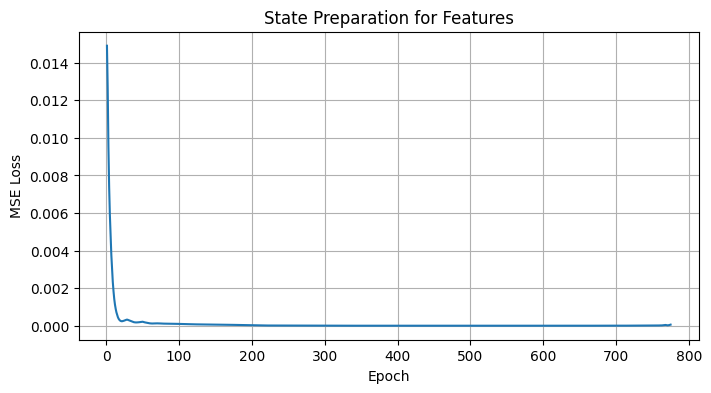

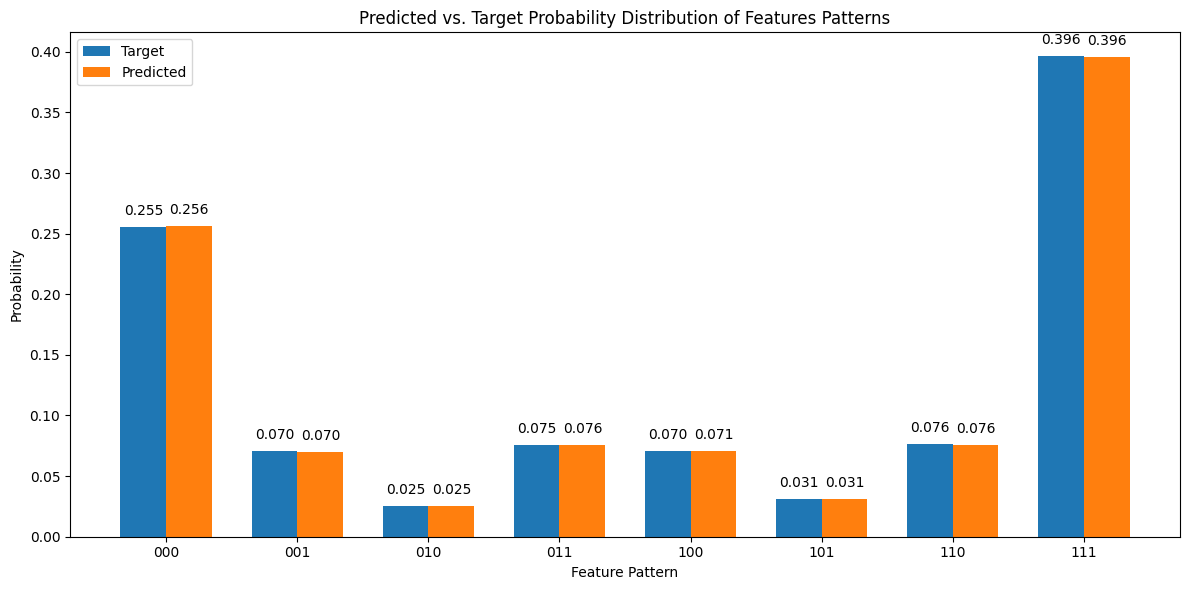

0: ──H──RY(0.07)───RZ(-0.14)─╭●────╭X──RY(-0.49)──RZ(-0.32)─╭●────╭X──RY(-0.48)──RZ(0.37)──╭●─── ···
1: ──H──RY(-0.31)──RZ(-0.11)─╰X─╭●─│───RY(0.06)───RZ(0.12)──╰X─╭●─│───RY(0.09)───RZ(-0.63)─╰X─╭● ···
2: ──H──RY(-0.03)──RZ(-0.07)────╰X─╰●──RY(0.16)───RZ(0.25)─────╰X─╰●──RY(-0.48)──RZ(-0.46)────╰X ···

0: ··· ─╭X─┤ ╭Probs
1: ··· ─│──┤ ├Probs
2: ··· ─╰●─┤ ╰Probs
Beginning Ansatz Training for Target
Epoch 50 - MSE Loss: 0.002496751 - Best: 0.002496751 - Stalled: 0/200
Epoch 50 - MSE Loss: 0.002496751 - Best: 0.002496751 - Stalled: 0/200
Epoch 100 - MSE Loss: 0.001021717 - Best: 0.001021717 - Stalled: 0/200
Epoch 100 - MSE Loss: 0.001021717 - Best: 0.001021717 - Stalled: 0/200
Epoch 150 - MSE Loss: 0.000286349 - Best: 0.000286349 - Stalled: 0/200
Epoch 150 - MSE Loss: 0.000286349 - Best: 0.000286349 - Stalled: 0/200
Epoch 200 - MSE Loss: 0.000128217 - Best: 0.000128217 - Stalled: 0/200
Epoch 200 - MSE Loss: 0.000128217 - Best: 0.000128217 - Stalled: 0/200
Epoch 250 - MSE Loss: 0.000066975

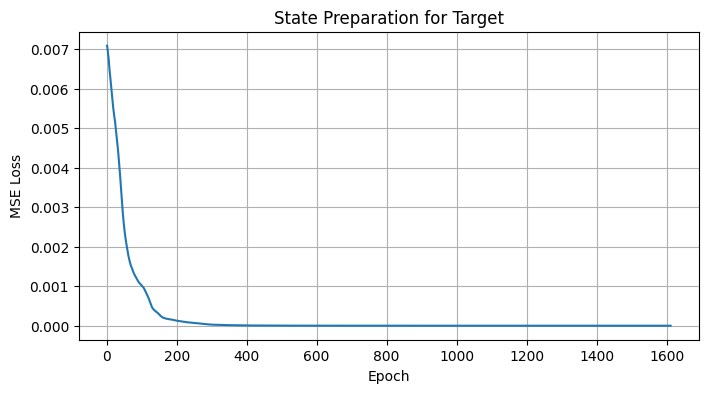

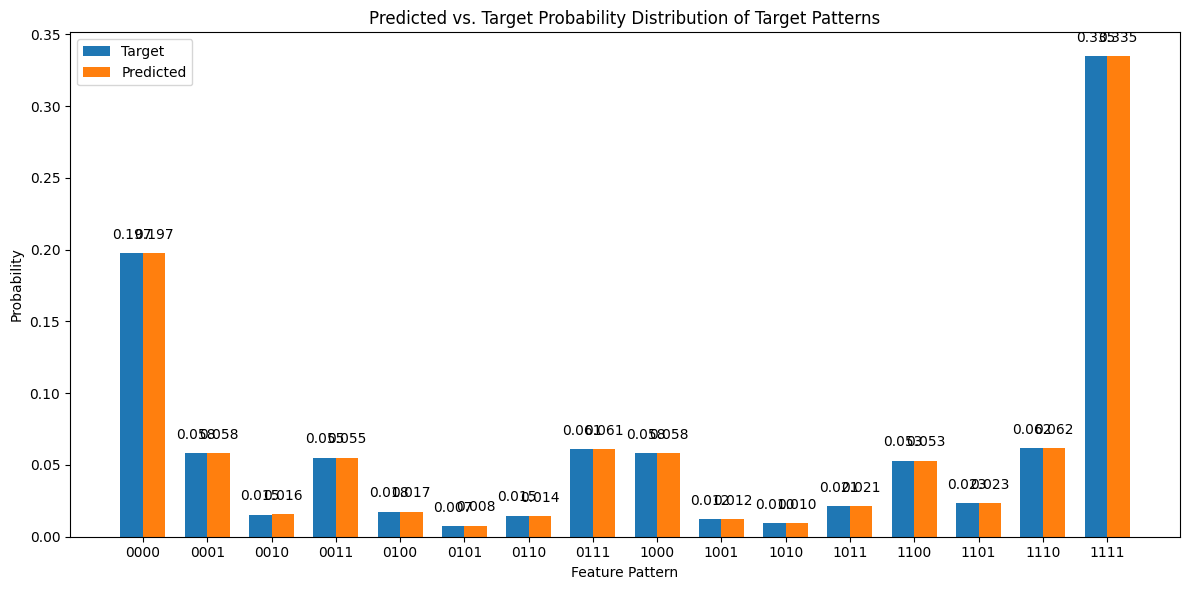

0: ──H──RY(0.03)───RZ(0.01)──╭●───────╭X──RY(-0.25)──RZ(-0.05)─╭●───────╭X──RY(-0.38)──RZ(-0.07) ···
1: ──H──RY(-0.26)──RZ(-0.02)─╰X─╭●────│───RY(0.05)───RZ(-0.00)─╰X─╭●────│───RY(0.04)───RZ(0.00)─ ···
2: ──H──RY(0.08)───RZ(0.09)─────╰X─╭●─│───RY(-0.42)──RZ(-0.07)────╰X─╭●─│───RY(0.05)───RZ(0.12)─ ···
3: ──H──RY(0.07)───RZ(-0.02)───────╰X─╰●──RY(0.07)───RZ(-0.06)───────╰X─╰●──RY(-0.09)──RZ(0.03)─ ···

0: ··· ─╭●───────╭X──RY(0.02)───RZ(-0.04)─╭●───────╭X─┤ ╭Probs
1: ··· ─╰X─╭●────│───RY(0.08)───RZ(-0.16)─╰X─╭●────│──┤ ├Probs
2: ··· ────╰X─╭●─│───RY(-0.56)──RZ(0.12)─────╰X─╭●─│──┤ ├Probs
3: ··· ───────╰X─╰●──RY(-0.52)──RZ(0.09)────────╰X─╰●─┤ ╰Probs
Beginning Ansatz Training for Context
Epoch 50 - MSE Loss: 0.000138136 - Best: 0.000009501 - Stalled: 49/200
Epoch 50 - MSE Loss: 0.000138136 - Best: 0.000009501 - Stalled: 49/200
Epoch 100 - MSE Loss: 0.000008698 - Best: 0.000006678 - Stalled: 2/200
Epoch 100 - MSE Loss: 0.000008698 - Best: 0.000006678 - Stalled: 2/200
Epoch 150 - MSE Loss:

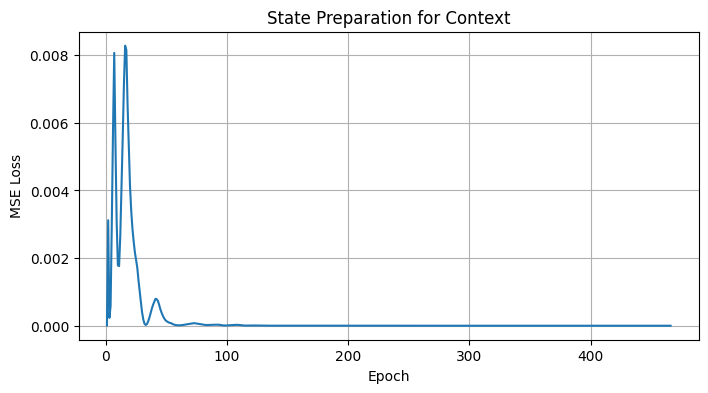

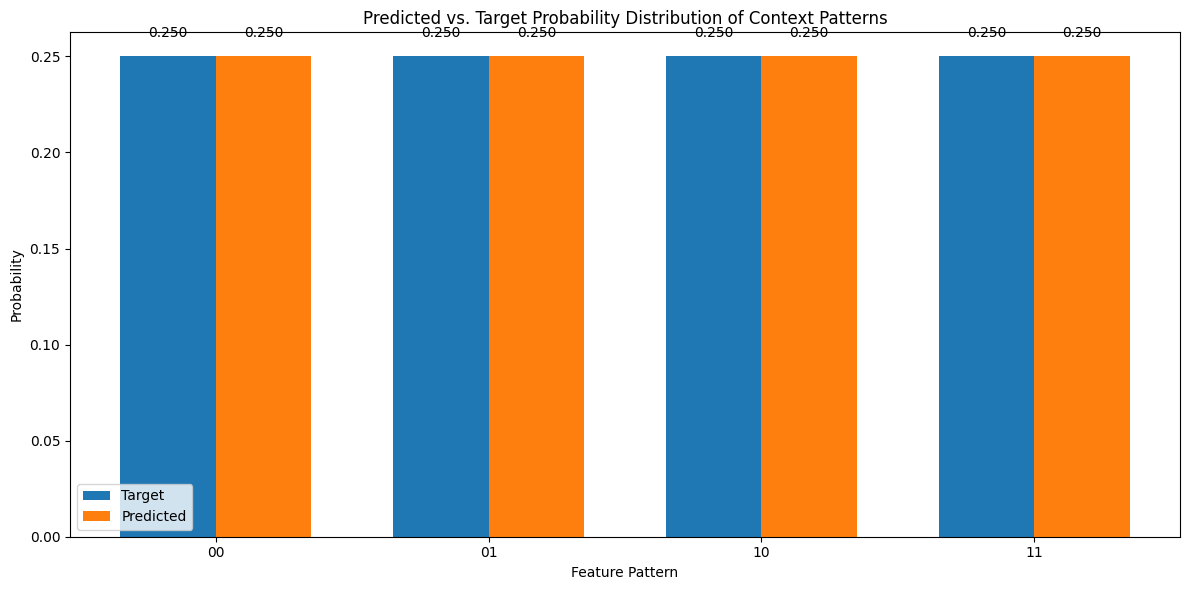

0: ──H──RY(-0.01)──RZ(-1.57)─╭●─╭X──RY(-0.21)──RZ(-0.34)─╭●─╭X─┤ ╭Probs
1: ──H──RY(-0.00)──RZ(0.47)──╰X─╰●──RY(0.53)───RZ(-0.97)─╰X─╰●─┤ ╰Probs


In [33]:
# train ansatz for all three states to prep

feature_probs_torch = torch.tensor(feature_probs, dtype=torch.float64)
output_probs_torch = torch.tensor(output_probs, dtype=torch.float64)
context_probs_torch = torch.tensor(context_dist, dtype=torch.float64)

sp_params = nn.ParameterDict()

L_list = [3, 4, L_SP]

sp_params['feature'] = train_ansatz(feature_probs_torch, 'Features', L=L_list[0], lr=0.05)
sp_params['target'] = train_ansatz(output_probs_torch, 'Target', L=L_list[1], lr=0.01)
sp_params['context'] = train_ansatz(context_probs_torch, 'Context', L=L_list[2])

#save parameters so that re-training is not necessary
torch.save(sp_params, 'sp_params.pth')

## Create Prediction Circuit (Quantum Multi-Task Learning)

In [34]:
#Build the circuit

# 0-1: context qubits
# 2-4: input qubits
# 5: output qubit
N_CONTEXT_WIRES = n_context  # Number of qubits needed to represent stocks
N_OUTPUT_WIRES = int(np.log2(N_BINS))
N_INPUT_WIRES = WINDOW_SIZE - N_OUTPUT_WIRES
N_TARGET_WIRES = N_INPUT_WIRES + N_OUTPUT_WIRES
N_TOTAL_WIRES = N_CONTEXT_WIRES + N_INPUT_WIRES + N_OUTPUT_WIRES + N_TARGET_WIRES + 1 #ancillary qubit

N_LAYERS = 2

input_wires = list(range(N_INPUT_WIRES))
output_wires = list(range(N_INPUT_WIRES, N_INPUT_WIRES + N_OUTPUT_WIRES))
context_wires = list(range(N_INPUT_WIRES + N_OUTPUT_WIRES, N_INPUT_WIRES + N_OUTPUT_WIRES + N_CONTEXT_WIRES))
target_wires = list(range(N_INPUT_WIRES + N_OUTPUT_WIRES + N_CONTEXT_WIRES, N_TOTAL_WIRES - 1))
ancillary_wire = N_TOTAL_WIRES - 1
comp_wires = list(range(N_INPUT_WIRES + N_OUTPUT_WIRES))

#load params
sp_params = torch.load('sp_params.pth', weights_only=False)

# Define device using simulator for training
dev = qml.device("default.qubit", wires=N_TOTAL_WIRES)

# layer for both either the shared or specify ansatz (input is just trainable parameters)
def U_ss(params):
    """A single (L=1) ansatz layer (Rotations + CNOTs)."""
    # 1. Trainable Rotations
    for i, wire in enumerate(comp_wires):
        qml.RY(params[i][0], wires=wire)
        qml.RZ(params[i][1], wires=wire)
    
    # 2. Entangling "Ring"
    for i in range(len(comp_wires)):
        qml.CNOT(wires=[comp_wires[i], comp_wires[(i + 1) % len(comp_wires)]])

# "Share & Specify" ansatz for training
def ss_ansatz(params, n_layers):
#Implement shared variational layers
    for l in range(n_layers):
        U_ss(params['shared'][l])

    # Implement control gates for specify layers
        for context_state in context_states:

            # Convert binary context_state (list/array of 0/1) to integer index and control string
            context_idx = int(''.join(map(str, context_state)), 2)

            # Apply controlled U_ss using the control bitstring and index into the spec params
            qml.ctrl(U_ss, control=context_wires, control_values=context_state)(params['spec'][context_idx][l])

# SWAP test implementation
def SWAP_test():
    qml.Hadamard(wires=ancillary_wire)

    for i in range(N_TARGET_WIRES):
        # CSWAP gate
        qml.CSWAP(wires=[ancillary_wire, comp_wires[i], target_wires[i]])
    
    qml.Hadamard(wires=ancillary_wire)

@qml.qnode(dev, interface='torch', diff_method='spsa')
def qmtl_circuit(params): # context is a classical input for now
    
    # State preparation for features, targets, & contexts
    hardware_efficient_ansatz(sp_params['feature'], input_wires, L_list[0])
    hardware_efficient_ansatz(sp_params['target'], target_wires, L_list[1])
    hardware_efficient_ansatz(sp_params['context'], context_wires, L_list[2])
    
    qml.Barrier(range(N_TOTAL_WIRES))
    # Share & Specify ansatz
    ss_ansatz(params, N_LAYERS)

    qml.Barrier(range(N_TOTAL_WIRES))
    
    # perform SWAP test
    SWAP_test()

    # Measure fidelity (1 - P(0) in ancillary qubit)
    return qml.probs(ancillary_wire)



--- Starting Training (with early stopping) ---
Epoch 10 - Fidelity Loss: 0.470676 - Best: 0.470676 - Stalled: 0/100
Epoch 10 - Fidelity Loss: 0.470676 - Best: 0.470676 - Stalled: 0/100
Epoch 20 - Fidelity Loss: 0.467486 - Best: 0.467486 - Stalled: 0/100
Epoch 20 - Fidelity Loss: 0.467486 - Best: 0.467486 - Stalled: 0/100
Epoch 30 - Fidelity Loss: 0.464505 - Best: 0.464505 - Stalled: 0/100
Epoch 30 - Fidelity Loss: 0.464505 - Best: 0.464505 - Stalled: 0/100
Epoch 40 - Fidelity Loss: 0.460366 - Best: 0.460366 - Stalled: 0/100
Epoch 40 - Fidelity Loss: 0.460366 - Best: 0.460366 - Stalled: 0/100
Epoch 50 - Fidelity Loss: 0.455570 - Best: 0.455570 - Stalled: 0/100
Epoch 50 - Fidelity Loss: 0.455570 - Best: 0.455570 - Stalled: 0/100
Epoch 60 - Fidelity Loss: 0.452970 - Best: 0.452970 - Stalled: 0/100
Epoch 60 - Fidelity Loss: 0.452970 - Best: 0.452970 - Stalled: 0/100
Epoch 70 - Fidelity Loss: 0.450127 - Best: 0.450127 - Stalled: 0/100
Epoch 70 - Fidelity Loss: 0.450127 - Best: 0.450127 - 

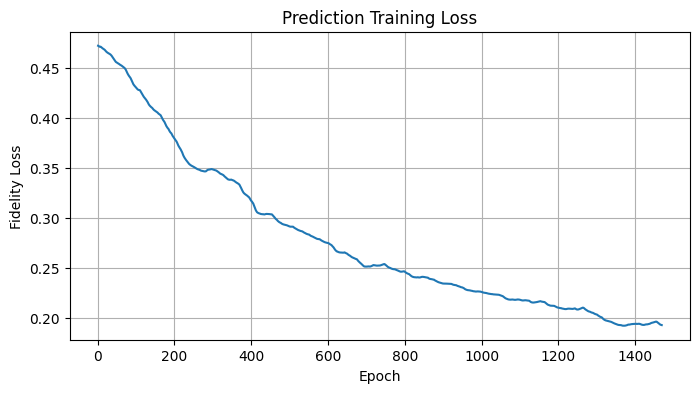

In [35]:
#Train prediction circuit

LEARNING_RATE = 0.01
# We use a large max epoch but rely on early stopping
N_EPOCHS = 10000
PATIENCE = 100  # early-stopping patience (epochs)
MIN_DELTA = 1e-6  # minimum improvement required to reset patience

def init_params():
    """
    Initialize the trainable parameters using torch.nn.Parameter
    """
    n_params_per_layer = len(comp_wires) # 3 input + 1 output = 4
    
    # --- Shared Parameters ---
    # We need L=2 layers of 4 params each
    shared_params = torch.randn(N_LAYERS, n_params_per_layer, 2, requires_grad=True)
    
    # --- Specify Parameters ---
    # We need K=4 sets of (L=2 layers * 4 params each)
    n_stocks = 2**N_CONTEXT_WIRES
    spec_params = torch.randn(n_stocks, N_LAYERS, n_params_per_layer, 2, requires_grad=True)
    
    # We use torch.nn.ParameterDict to keep them organized
    return nn.ParameterDict({
        "shared": nn.Parameter(shared_params),
        "spec": nn.Parameter(spec_params)
    })

#Train the circuit
params = init_params()

optimizer = torch.optim.Adam(params.values(), lr=LEARNING_RATE)

def fidelity_loss(params):
    # Run circuit
    y_pred = qmtl_circuit(params)

    return 1 - y_pred[0]  # Fidelity loss: 1 - P(0)

print("\n--- Starting Training (with early stopping) ---")
# --- Run Epochs ---
loss_hist = []
best_loss = float('inf')
epochs_no_improve = 0
# Keep a copy of best params (as detached clones)
best_params = {k: v.detach().clone() for k, v in params.items()}

for epoch in range(N_EPOCHS):
    # Do Quantum Batch Gradient Update (QBGU)
    loss = fidelity_loss(params)

    # Calculate Gradients
    # PyTorch and PennyLane work together to run the parameter-shift rule for ALL parameters.
    loss.backward()

    # Update parameters
    optimizer.step()

    # Clear gradients
    optimizer.zero_grad()

    loss_value = loss.item()
    loss_hist.append(loss_value)

    # Check improvement for early stopping
    if loss_value < best_loss - MIN_DELTA:
        best_loss = loss_value
        epochs_no_improve = 0
        # save best params
        best_params = {k: v.detach().clone() for k, v in params.items()}
    else:
        epochs_no_improve += 1

    # Print progress
    if (epoch + 1) % max(1, (PATIENCE // 10)) == 0 or epoch == N_EPOCHS - 1:
        print(f"Epoch {epoch+1} - Fidelity Loss: {loss_value:.6f} - Best: {best_loss:.6f} - Stalled: {epochs_no_improve}/{PATIENCE}")

    # Early stopping check
    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch+1} (no improvement for {PATIENCE} epochs).")
        break

# After training, restore the best-found parameters
with torch.no_grad():
    for k in params.keys():
        params[k].data.copy_(best_params[k])

#save params
torch.save(params, 'ss_params.pth')

print("--- Training Complete ---")
print("Final Parameters (Shared):")
print(params['shared'])
print("Final Parameters (Specify):")
print(params['spec'])

# Plot loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(loss_hist) + 1), loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Fidelity Loss')
plt.title('Prediction Training Loss')
plt.grid(True)
plt.show()

In [36]:
#load params
params = torch.load('ss_params.pth', weights_only=False)

#Plot the final circuit

# 0: Input 1
# 1: Input 2
# 2: Input 3
# 3: Output
# 4: Context 1
# 5: Context 2
# 6: Target 1
# 7: Target 2
# 8: Target 3
# 9: Target 4 (output)
# 10: Ancillary

print(qml.draw(qmtl_circuit)(params))
#print(qml.draw_mpl(qmtl_circuit)(params))

 0: ──H──RY(0.07)───RZ(-0.14)─╭●────╭X──────────RY(-0.49)──RZ(-0.32)─╭●────────────╭X──RY(-0.48) ···
 1: ──H──RY(-0.31)──RZ(-0.11)─╰X─╭●─│───────────RY(0.06)───RZ(0.12)──╰X─────────╭●─│───RY(0.09)─ ···
 2: ──H──RY(-0.03)──RZ(-0.07)────╰X─╰●──────────RY(0.16)───RZ(0.25)─────────────╰X─╰●──RY(-0.48) ···
 3: ──────────────────────────────────────────────────────────────────────────────────────────── ···
 4: ──H──RY(-0.01)──RZ(-1.57)─╭●─╭X──RY(-0.21)──RZ(-0.34)─╭●─────────╭X───────────────────────── ···
 5: ──H──RY(-0.00)──RZ(0.47)──╰X─╰●──RY(0.53)───RZ(-0.97)─╰X─────────╰●───────────────────────── ···
 6: ──H──RY(0.03)───RZ(0.01)──╭●───────────────╭X──────────RY(-0.25)──RZ(-0.05)─╭●────────────── ···
 7: ──H──RY(-0.26)──RZ(-0.02)─╰X─╭●────────────│───────────RY(0.05)───RZ(-0.00)─╰X─╭●─────────── ···
 8: ──H──RY(0.08)───RZ(0.09)─────╰X─╭●─────────│───────────RY(-0.42)──RZ(-0.07)────╰X─╭●──────── ···
 9: ──H──RY(0.07)───RZ(-0.02)───────╰X─────────╰●──────────RY(0.07)───RZ(-0.06)───────╰X───

# Testing
We run the trained algorithm on the test set classically, one-by-one, to determine accuracy and precision.

In [ ]:
# Split test windows and prepare quantum states

# Create columns for input and target from each window
df_test['input'] = df_test['window'].apply(lambda x: x[:WINDOW_SIZE-1])  # First 3 entries
df_test['target'] = df_test['window'].apply(lambda x: x[-1])  # Last entry

@qml.qnode(dev_test)
def prepare_input_state(input_vector):
    """Prepare input vector as quantum basis state."""
    qml.BasisState(input_vector, wires=input_wires)
    return qml.probs(wires=input_wires)


Test data shape: (1204, 4)

First 5 samples:
  context        window      input  target
0       0  [0, 1, 1, 1]  [0, 1, 1]       1
1       0  [1, 1, 1, 1]  [1, 1, 1]       1
2       0  [1, 1, 1, 1]  [1, 1, 1]       1
3       0  [1, 1, 1, 1]  [1, 1, 1]       1
4       0  [1, 1, 1, 1]  [1, 1, 1]       1

First input vector: [0 1 1]
First target: 1

Preparing quantum input states...
Sample 0: input=[0 1 1], target=1, state_probs=[0. 0. 0. 1. 0. 0. 0. 0.]
Sample 1: input=[1 1 1], target=1, state_probs=[0. 0. 0. 0. 0. 0. 0. 1.]
Sample 2: input=[1 1 1], target=1, state_probs=[0. 0. 0. 0. 0. 0. 0. 1.]

Successfully prepared 1204 quantum input states

Successfully prepared 1204 quantum input states
